In [1]:
#meta 3/7/2021 Numerai Starter - Linear regression 
#src https://www.kaggle.com/carlolepelaars/how-to-get-started-with-numerai

#history
# 3/7/2021 NUMERAI STARTER: EDA, LINEAR MODEL, EVALUATE METRICS
#     Cobmined code from multiple sources.
#     Key source for metrics: #src https://www.kaggle.com/carlolepelaars/how-to-get-started-with-numerai
#     Want to understand how to evaluate linear models since we're not using common MSE or RMSE metrics.

In [2]:
# Install Numerai's API
!pip install numerapi
# Get the latest version of Weights and Biases
!pip install wandb --upgrade

# Numerai

In [3]:
import numerapi

import os
import time
import numpy as np
import pandas as pd
# Surpress Pandas warnings
pd.set_option('chained_assignment', None)
import matplotlib.pyplot as plt

import sklearn.linear_model
from sklearn.metrics import mean_absolute_error
from scipy.stats import spearmanr

from joblib import dump, load


In [4]:
'''
import random as rn
import seaborn as sns
import lightgbm as lgb

# Weights and Biases
import wandb
from wandb.lightgbm import wandb_callback
wandb.login(key=WANDB_KEY)
'''

'\nimport random as rn\nimport seaborn as sns\nimport lightgbm as lgb\n\n# Weights and Biases\nimport wandb\nfrom wandb.lightgbm import wandb_callback\nwandb.login(key=WANDB_KEY)\n'

In [5]:
# Set global vars
# Initialize Numerai's API
napi = numerapi.NumerAPI(verbosity="info")

# Data directory
DIR = "/kaggle/working"

# Set seed for reproducability
SEED = 1234
#rn.seed(seed)
#np.random.seed(seed)
#os.environ['PYTHONHASHSEED'] = str(seed)

#track time
t0 = time.time()

In [6]:
# Define global functions

# get latest data
# src https://www.kaggle.com/carlolepelaars/how-to-get-started-with-numerai
def download_current_data(directory: str):
    """
    Downloads the data for the current round
    :param directory: The path to the directory where the data needs to be saved
    """
    current_round = napi.get_current_round()
    if os.path.isdir(f'{directory}/numerai_dataset_{current_round}/'):
        print(f"You already have the newest data! Current round is: {current_round}")
    else:
        print(f"Downloading new data for round: {current_round}!")
        napi.download_current_dataset(dest_path=directory, unzip=True)

def load_data0(directory: str, reduce_memory: bool=True) -> tuple:
    """
    Get data for current round
    :param directory: The path to the directory where the data needs to be saved
    :return: A tuple containing the datasets
    """
    print('Loading the data')
    full_path = f'{directory}/numerai_dataset_{NAPI.get_current_round()}/'
    train_path = full_path + 'numerai_training_data.csv'
    test_path = full_path + 'numerai_tournament_data.csv'
    train = pd.read_csv(train_path)
    test = pd.read_csv(test_path)
    
    # Reduce all features to 32-bit floats
    if reduce_memory:
        num_features = [f for f in train.columns if f.startswith("feature")]
        train[num_features] = train[num_features].astype(np.float32)
        test[num_features] = test[num_features].astype(np.float32)
        
    val = test[test['data_type'] == 'validation']
    return train, val, test

def load_data(directory: str, reduce_memory: bool=True) -> tuple:
    """
    Get data for current round
    :param directory: The path to the directory where the data needs to be saved
    :return: A tuple containing the datasets
    """
    print('Loading the data')
    full_path = f'{directory}/numerai_dataset_{napi.get_current_round()}/'
    train_path = full_path + 'numerai_training_data.csv'
    tournament_path = full_path + 'numerai_tournament_data.csv'
    train = pd.read_csv(train_path)
    tournament = pd.read_csv(tournament_path)
    
    # Reduce all features to 32-bit floats
    if reduce_memory:
        col_features = [f for f in train.columns if f.startswith("feature")]
        train[col_features] = train[col_features].astype(np.float32)
        tournament[col_features] = tournament[col_features].astype(np.float32)
        
    return train, tournament

## 0. Load Data

#### Datasets 
*   `training_data` is used to train your model
*   `tournament_data` is used to evaluate your model

#### Column descriptions
*   id: a randomized id that corresponds to a stock 
*   era: a period of time
*   data_type: either `train`, `validation`, `test`, or `live` 
*   feature_*: abstract financial features of the stock 
*   target: abstract measure of stock performance

In [7]:
#download competition data
##napi.get_current_round()
##napi.download_current_dataset()
download_current_data(DIR)

You already have the newest data! Current round is: 254


In [8]:
#unzip and load
training_data, tournament_data = load_data(DIR, reduce_memory=True)
training_data.shape, tournament_data.shape

Loading the data


((501808, 314), (1665898, 314))

In [9]:
print ("Loading data completed time (in min).  Data downloaded, unzipped and loaded.", (time.time() - t0)/60)

print("Training set info:")
training_data.info()
print("\nTournament set info:")
tournament_data.info()

Loading data completed time (in min).  Data downloaded, unzipped and loaded. 4.429011921087901
Training set info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501808 entries, 0 to 501807
Columns: 314 entries, id to target
dtypes: float32(310), float64(1), object(3)
memory usage: 608.7+ MB

Tournament set info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1665898 entries, 0 to 1665897
Columns: 314 entries, id to target
dtypes: float32(310), float64(1), object(3)
memory usage: 2.0+ GB


In [10]:
training_data.head()

,id,era,data_type,feature_intelligence1,feature_intelligence2,feature_intelligence3,feature_intelligence4,feature_intelligence5,feature_intelligence6,feature_intelligence7,...,feature_wisdom38,feature_wisdom39,feature_wisdom40,feature_wisdom41,feature_wisdom42,feature_wisdom43,feature_wisdom44,feature_wisdom45,feature_wisdom46,target
0,n000315175b67977,era1,train,0.00,0.50,0.25,0.00,0.5,0.25,0.25,...,1.00,1.00,0.75,0.50,0.75,0.50,1.00,0.50,0.75,0.50
1,n0014af834a96cdd,era1,train,0.00,0.00,0.00,0.25,0.5,0.00,0.00,...,1.00,1.00,0.00,0.00,0.75,0.25,0.00,0.25,1.00,0.25
2,n001c93979ac41d4,era1,train,0.25,0.50,0.25,0.25,1.0,0.75,0.75,...,0.25,0.50,0.00,0.00,0.50,1.00,0.00,0.25,0.75,0.25
3,n0034e4143f22a13,era1,train,1.00,0.00,0.00,0.50,0.5,0.25,0.25,...,1.00,1.00,0.75,0.75,1.00,1.00,0.75,1.00,1.00,0.25
4,n00679d1a636062f,era1,train,0.25,0.25,0.25,0.25,0.0,0.25,0.50,...,0.75,0.75,0.25,0.50,0.75,0.00,0.50,0.25,0.75,0.75


### 0.1 EDA
Distributions, Missing data


In [11]:
training_data.data_type.unique(), tournament_data.data_type.unique()

(array(['train'], dtype=object),
 array(['validation', 'test', 'live'], dtype=object))

In [12]:
training_data['target'].describe(), tournament_data['target'].describe()

(count    501808.000000
 mean          0.499997
 std           0.223268
 min           0.000000
 25%           0.500000
 50%           0.500000
 75%           0.500000
 max           1.000000
 Name: target, dtype: float64,
 count    137779.000000
 mean          0.500015
 std           0.223491
 min           0.000000
 25%           0.500000
 50%           0.500000
 75%           0.500000
 max           1.000000
 Name: target, dtype: float64)

Text(0.5, 1.0, 'Target value - Tournament ds')

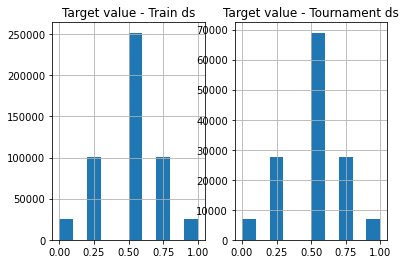

In [13]:
#plot histograms
fig, ax = plt.subplots(1, 2)
training_data['target'].hist(ax=ax[0]); 
tournament_data['target'].hist(ax=ax[1]);
ax[0].set_title('Target value - Train ds')
ax[1].set_title('Target value - Tournament ds')

#### Missing Targets
Train has no missing targets.  
Notice missing targets in tournament dataset: none missing in Valid, all missing in Test and Live.

In [14]:
training_data['target'].value_counts(dropna=False), tournament_data['target'].value_counts(dropna=False)

(0.50    251677
 0.25    100053
 0.75    100045
 1.00     25017
 0.00     25016
 Name: target, dtype: int64,
 NaN     1528119
 0.50      68954
 0.75      27533
 0.25      27531
 1.00       6882
 0.00       6879
 Name: target, dtype: int64)

In [15]:
#check nulls
(training_data['target'].isnull().sum(), training_data['target'].notnull().sum()), (tournament_data['target'].isnull().sum(), tournament_data['target'].notnull().sum())

((0, 501808), (1528119, 137779))

#### Eras
120 eras in the train dataset.  Era sizes change over time.

In [16]:
training_data['era'].describe()

count     501808
unique       120
top        era55
freq        4893
Name: era, dtype: object

<AxesSubplot:title={'center':'Counts by Era - Training Data'}, xlabel='era_number'>

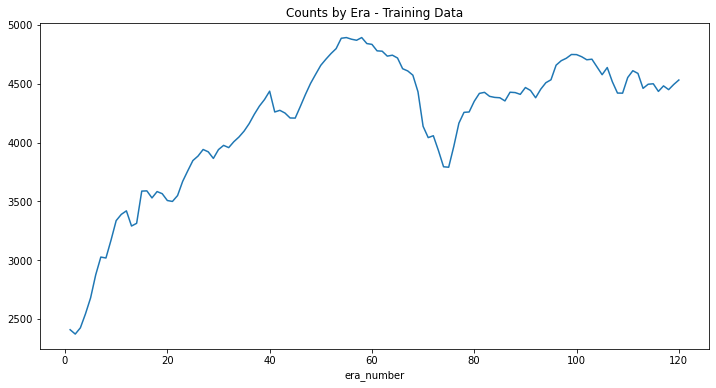

In [17]:
training_data['era_number'] = training_data['era'].str.slice(3).astype(int)
training_data.groupby('era_number')['id'].count().plot(title= "Counts by Era - Training Data",  figsize=(12, 6))

## 1. Data Prep

In [18]:
#split into datasets
valid_idx = tournament_data.index[tournament_data.data_type=='validation'].tolist()
df_valid = tournament_data.iloc[valid_idx]


X&y
The features are divided into 6 groups: intelligence, wisdom, charisma, dexterity, strength and constitution.

In [19]:
# define the feature columns
col_features = training_data.columns[training_data.columns.str.startswith('feature')]

X_train = training_data[col_features]
y_train = training_data['target']
X_valid = df_valid[col_features]
y_valid = df_valid['target']

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((501808, 310), (501808,), (137779, 310), (137779,))

#### Confirm Missing Targets
Train and Valid none are missing, Test and Live all are missing.

In [20]:
#check nulls - numbers must match
(y_train.isnull().sum(), y_train.notnull().sum()), (y_valid.isnull().sum(), y_valid.notnull().sum())

((0, 501808), (0, 137779))

## 2. Model
Start with simplest Linear regression

In [21]:
#track time
t0_model = time.time()

# train a model to make predictions on tournament data
model = sklearn.linear_model.LinearRegression()
model.fit(X_train, y_train)

print ("Training time (in min)", (time.time() - t0_model)/60)

Training time (in min) 0.0847750186920166


In [22]:
#save model
dump(model, "model_linear.pkl")

print ("Training completed time (in min).  Model saved.", (time.time() - t0)/60)

Training completed time (in min).  Model saved. 4.575145928064982


## 3. Evaluate Model

In [48]:
def sharpe_ratio(corrs: pd.Series) -> np.float32:
    """
    Calculate the Sharpe ratio for Numerai by using grouped per-era data
    
    :param corrs: A Pandas Series containing the Spearman correlations for each era
    :return: A float denoting the Sharpe ratio of your predictions.
    """
    return corrs.mean() / corrs.std()


def evaluate(df: pd.DataFrame) -> tuple:
    """
    Evaluate and display relevant metrics for Numerai 
    
    :param df: A Pandas DataFrame containing the columns "era", "target" and "prediction"
    :return: A tuple of float containing the metrics
    """
    def _score(sub_df: pd.DataFrame) -> np.float32:
        """Calculates Spearman correlation"""
        return spearmanr(sub_df["target"], sub_df["prediction"])[0]
    
    # Calculate metrics
    corrs = df.groupby("era").apply(_score)
    payout_raw = (corrs / 0.2).clip(-1, 1)
    spearman = round(corrs.mean(), 4)
    payout = round(payout_raw.mean(), 4)
    numerai_sharpe = round(sharpe_ratio(corrs), 4)
    mae = mean_absolute_error(df["target"], df["prediction"]).round(4)

    # Display metrics
    print(f"Spearman Correlation: {spearman}")
    print(f"Average Payout: {payout}")
    print(f"Sharpe Ratio: {numerai_sharpe}")
    print(f"Mean Absolute Error (MAE): {mae}")
    return spearman, payout, numerai_sharpe, mae


In [24]:
# Create predictions from model - on Validation dataset
training_data.loc[:,"prediction"] = model.predict(X_train)
df_valid.loc[:,"prediction"] = model.predict(X_valid)
training_data[['target','prediction']].head(), df_valid[['target','prediction']].head()

(   target  prediction
 0    0.50    0.501301
 1    0.25    0.517580
 2    0.25    0.495422
 3    0.25    0.506792
 4    0.75    0.498840,
    target  prediction
 0    0.25    0.481608
 1    0.50    0.492837
 2    1.00    0.530817
 3    0.50    0.497083
 4    0.75    0.503089)

In [25]:
# Evaluate Model
print("--- Final Training Scores ---")
spearman, payout, numerai_sharpe, mae = evaluate(training_data)
print("\n--- Final Validation Scores ---")
spearman, payout, numerai_sharpe, mae = evaluate(df_valid)

--- Final Training Scores ---
Spearman Correlation: 0.0528
Average Payout: 0.2642
Sharpe Ratio: 1.6928
Mean Absolute Error (MAE): 0.1537

--- Final Validation Scores ---
Spearman Correlation: 0.0162
Average Payout: 0.0812
Sharpe Ratio: 0.5237
Mean Absolute Error (MAE): 0.1543


### 3.1 Post-EDA 

In [26]:
df_valid['era_number'] = df_valid['era'].str.slice(3).astype(int)
df_valid['era'].describe(), df_valid['era_number'].describe()


(count     137779
 unique        28
 top       era210
 freq        5227
 Name: era, dtype: object,
 count    137779.000000
 mean        172.706378
 std          38.574384
 min         121.000000
 25%         128.000000
 50%         199.000000
 75%         206.000000
 max         212.000000
 Name: era_number, dtype: float64)

<AxesSubplot:title={'center':'Counts by Era - Validation Data'}, xlabel='era_number'>

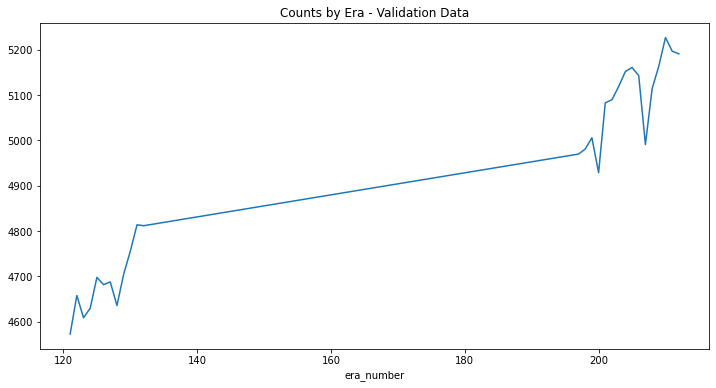

In [27]:
df_valid.groupby('era_number')['id'].count().plot(title= "Counts by Era - Validation Data",  figsize=(12, 6))

Text(0.5, 1.0, 'Target value - Validation ds')

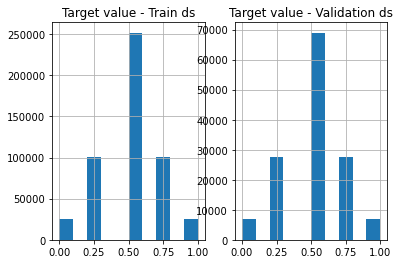

In [28]:
#plot histograms
fig, ax = plt.subplots(1, 2)
training_data['target'].hist(ax=ax[0]); 
df_valid['target'].hist(ax=ax[1]);
ax[0].set_title('Target value - Train ds')
ax[1].set_title('Target value - Validation ds')

Text(0.5, 1.0, 'Prediction value - Validation ds')

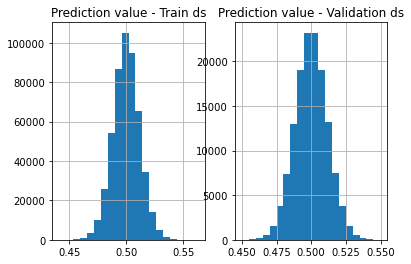

In [29]:
#plot histograms
fig, ax = plt.subplots(1, 2)
training_data['prediction'].hist(ax=ax[0], bins=20); 
df_valid['prediction'].hist(ax=ax[1], bins=20);
ax[0].set_title('Prediction value - Train ds')
ax[1].set_title('Prediction value - Validation ds')

In [30]:
print ("Evaluation completed time (in min).  Models evaluated: train and validation datasets.", (time.time() - t0)/60)

Evaluation completed time (in min).  Models evaluated: train and validation datasets. 4.627501098314921


Free up some memory

In [40]:
#get all dfs
# Simply evaluate and test whether they are pandas dataframes
alldfs = [var for var in dir() if isinstance(eval(var), pd.core.frame.DataFrame)]
print(alldfs)

['df_valid', 'tournament_data', 'training_data']


In [34]:
import gc
print(gc.get_count())
del [[X_train, X_valid, _10]]
gc.collect()
print(gc.get_count())

#remaining dfs
alldfs = [var for var in dir() if isinstance(eval(var), pd.core.frame.DataFrame)]
print(alldfs)

(61, 0, 10)

## 4.0 Predict for Submission
Not evaluating full tournamanet ds, due to no values in `target` field.

In [42]:
# define the feature columns
X_tournament = tournament_data[col_features]
y_tournament = tournament_data['target']

X_tournament.shape, y_tournament.shape


((1665898, 310), (1665898,))

In [43]:
tournament_data.loc[:,"prediction"] = model.predict(X_tournament)
tournament_data[['target','prediction']].head()

,target,prediction
0,0.25,0.481608
1,0.50,0.492837
2,1.00,0.530817
3,0.50,0.497083
4,0.75,0.503089


In [51]:
# submit predictions to numer.ai - manually?
tournament_data[["id", "prediction"]].to_csv("predictions.csv", index=False)

print ("Submission dataset completed time (in min).  Submission saved to csv.", (time.time() - t0)/60)

Submission dataset completed time (in min).  Submission saved to csv. 33.41492936611176


### 4.1 Submission Post-EDA

In [57]:
tournament_data['era'].str.slice(3).unique()

array(['121', '122', '123', '124', '125', '126', '127', '128', '129',
       '130', '131', '132', '575', '576', '577', '578', '579', '580',
       '581', '582', '583', '584', '585', '586', '587', '588', '589',
       '590', '591', '592', '593', '594', '595', '596', '597', '598',
       '599', '600', '601', '602', '603', '604', '605', '606', '607',
       '608', '609', '610', '611', '612', '613', '614', '615', '616',
       '617', '618', '619', '620', '621', '622', '623', '624', '625',
       '626', '627', '628', '629', '630', '631', '632', '633', '634',
       '635', '636', '637', '638', '639', '640', '641', '642', '643',
       '644', '645', '646', '647', '648', '649', '650', '651', '652',
       '653', '654', '655', '656', '657', '658', '659', '660', '661',
       '662', '663', '664', '665', '666', '667', '668', '669', '670',
       '671', '672', '673', '674', '675', '676', '677', '678', '679',
       '680', '681', '682', '683', '684', '685', '686', '687', '688',
       '689', '690',

In [58]:
tournament_data['era_number'] = tournament_data['era'].str.slice(3) #.astype(int)
tournament_data['era'].describe(), tournament_data['era_number'].describe()


(count     1665898
 unique        329
 top          eraX
 freq         5396
 Name: era, dtype: object,
 count     1665898
 unique        329
 top             X
 freq         5396
 Name: era_number, dtype: object)

<AxesSubplot:title={'center':'Counts by Era - Tournament Data'}, xlabel='era_number'>

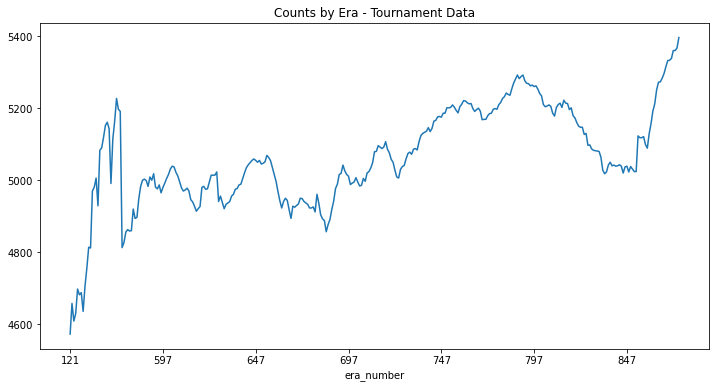

In [59]:
tournament_data.groupby('era_number')['id'].count().plot(title= "Counts by Era - Tournament Data",  figsize=(12, 6))

Text(0.5, 1.0, 'Prediction value - Tournament ds')

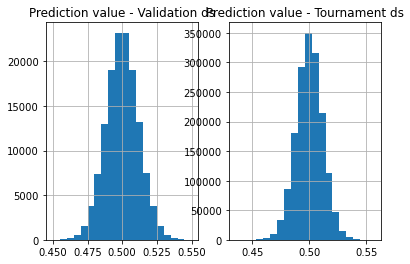

In [61]:
#plot histograms
fig, ax = plt.subplots(1, 2)
df_valid['prediction'].hist(ax=ax[0], bins=20);
tournament_data['prediction'].hist(ax=ax[1], bins=20);
ax[0].set_title('Prediction value - Validation ds')
ax[1].set_title('Prediction value - Tournament ds')